<a href="https://colab.research.google.com/github/pplateena/MMPAI-NULP/blob/main/l4/perceptron_ran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Lab 4: Neural Network Implementation with PyTorch
# Multi-Layer Perceptron for Titanic Survival Prediction

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("🚢 Lab 4: Neural Network Implementation with PyTorch")
print("="*60)
print("Building MLP for Titanic Survival Prediction")
print("="*60)

🚢 Lab 4: Neural Network Implementation with PyTorch
Building MLP for Titanic Survival Prediction


In [4]:
# Task 1: Data Loading and Preparation
print("="*50)
print("TASK 1: DATA LOADING AND PREPARATION")
print("="*50)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Load dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the preprocessed dataset from Lab 2
drive_path = '/content/drive/MyDrive/transformed_df.csv'
df = pd.read_csv(drive_path)

print(f"✅ Dataset loaded: {df.shape}")
print(f"📋 Columns: {list(df.columns)}")
print(f"🎯 Target distribution: {df['Survived'].value_counts().to_dict()}")

# Separate features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

print(f"\n📊 After preprocessing:")
print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Feature names: {list(X.columns)}")
print(f"   Survival rate: {y.mean():.3f}")

print("\n✅ Task 1 completed: Data loading and preparation finished")

TASK 1: DATA LOADING AND PREPARATION
🔧 Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset loaded: (891, 14)
📋 Columns: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'IsAlone', 'AgeCategory', 'FareCategory']
🎯 Target distribution: {0: 549, 1: 342}

📊 After preprocessing:
   Features shape: (891, 13)
   Target shape: (891,)
   Feature names: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'IsAlone', 'AgeCategory', 'FareCategory']
   Survival rate: 0.384

✅ Task 1 completed: Data loading and preparation finished


In [5]:
# Task 2: Data Splitting and Scaling
print("="*50)
print("TASK 2: DATA SPLITTING AND SCALING")
print("="*50)

# Convert to numpy arrays
X_np = X.values.astype(np.float32)
y_np = y.values.astype(np.float32)

# Split the data: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2
)

print(f"📊 Data split:")
print(f"   Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_np)*100:.1f}%)")
print(f"   Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_np)*100:.1f}%)")
print(f"   Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_np)*100:.1f}%)")

# Check class distribution
print(f"\n🎯 Class distribution:")
print(f"   Train: {np.bincount(y_train.astype(int))} (Survival rate: {y_train.mean():.3f})")
print(f"   Val:   {np.bincount(y_val.astype(int))} (Survival rate: {y_val.mean():.3f})")
print(f"   Test:  {np.bincount(y_test.astype(int))} (Survival rate: {y_test.mean():.3f})")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n📏 Feature scaling completed:")
print(f"   Original range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"   Scaled range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

y_train_tensor = torch.FloatTensor(y_train)
y_val_tensor = torch.FloatTensor(y_val)
y_test_tensor = torch.FloatTensor(y_test)

print(f"\n🔥 Converted to PyTorch tensors:")
print(f"   X_train: {X_train_tensor.shape}, dtype: {X_train_tensor.dtype}")
print(f"   y_train: {y_train_tensor.shape}, dtype: {y_train_tensor.dtype}")

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n📦 DataLoaders created:")
print(f"   Batch size: {batch_size}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

print("\n✅ Task 2 completed: Data splitting and scaling finished")

TASK 2: DATA SPLITTING AND SCALING
📊 Data split:
   Training set: 534 samples (59.9%)
   Validation set: 178 samples (20.0%)
   Test set: 179 samples (20.1%)

🎯 Class distribution:
   Train: [329 205] (Survival rate: 0.384)
   Val:   [110  68] (Survival rate: 0.382)
   Test:  [110  69] (Survival rate: 0.385)

📏 Feature scaling completed:
   Original range: [0.00, 3.00]
   Scaled range: [-3.10, 10.44]

🔥 Converted to PyTorch tensors:
   X_train: torch.Size([534, 13]), dtype: torch.float32
   y_train: torch.Size([534]), dtype: torch.float32

📦 DataLoaders created:
   Batch size: 32
   Training batches: 17
   Validation batches: 6
   Test batches: 6

✅ Task 2 completed: Data splitting and scaling finished


In [6]:
# Task 3: MLP Architecture Definition
print("="*50)
print("TASK 3: MLP ARCHITECTURE DEFINITION")
print("="*50)

class TitanicMLP(nn.Module):
    """
    Multi-Layer Perceptron for Titanic Survival Prediction

    Architecture:
    - Input layer: num_features
    - Hidden layer 1: 64 neurons + ReLU + Dropout
    - Hidden layer 2: 32 neurons + ReLU + Dropout
    - Hidden layer 3: 16 neurons + ReLU + Dropout
    - Output layer: 1 neuron + Sigmoid (for binary classification)
    """

    def __init__(self, num_features, dropout_rate=0.3):
        super(TitanicMLP, self).__init__()

        self.network = nn.Sequential(
            # Input layer
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Hidden layer 1
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Hidden layer 2
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Output layer
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights using Xavier initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.network(x)

# Get number of features
num_features = X_train_tensor.shape[1]

# Create model instance
model = TitanicMLP(num_features=num_features, dropout_rate=0.3)
model = model.to(device)

print(f"🧠 MLP Architecture:")
print(f"   Input features: {num_features}")
print(f"   Architecture: {num_features} → 64 → 32 → 16 → 1")
print(f"   Activation: ReLU (hidden layers), Sigmoid (output)")
print(f"   Dropout rate: 0.3")
print(f"   Weight initialization: Xavier Uniform")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Parameters:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

# Print model architecture
print(f"\n🏗️ Detailed Architecture:")
print(model)

# Model summary function
def model_summary(model, input_size):
    """Print model summary similar to Keras"""
    print(f"\n📋 Model Summary:")
    print("-" * 65)
    print(f"{'Layer':<15} {'Input Shape':<15} {'Output Shape':<15} {'Param #':<10}")
    print("-" * 65)

    total_params = 0
    x = torch.randn(1, input_size)

    for name, layer in model.named_children():
        if hasattr(layer, '__iter__'):
            for i, sublayer in enumerate(layer):
                if isinstance(sublayer, nn.Linear):
                    in_features = sublayer.in_features
                    out_features = sublayer.out_features
                    params = in_features * out_features + out_features
                    total_params += params

                    print(f"Linear_{i+1}      ({in_features:,})          ({out_features:,})          {params:,}")
                elif isinstance(sublayer, (nn.ReLU, nn.Dropout, nn.Sigmoid)):
                    layer_name = sublayer.__class__.__name__
                    if isinstance(sublayer, nn.Dropout):
                        layer_name += f"({sublayer.p})"
                    print(f"{layer_name:<15} {'':<15} {'':<15} {'0':<10}")

    print("-" * 65)
    print(f"Total params: {total_params:,}")
    print("-" * 65)

model_summary(model, num_features)

print("\n✅ Task 3 completed: MLP architecture defined")

TASK 3: MLP ARCHITECTURE DEFINITION
🧠 MLP Architecture:
   Input features: 13
   Architecture: 13 → 64 → 32 → 16 → 1
   Activation: ReLU (hidden layers), Sigmoid (output)
   Dropout rate: 0.3
   Weight initialization: Xavier Uniform

📊 Model Parameters:
   Total parameters: 3,521
   Trainable parameters: 3,521

🏗️ Detailed Architecture:
TitanicMLP(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=16, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

📋 Model Summary:
-----------------------------------------------------------------
Layer           Input Shape     Output Shape    Param #   
---------------------------------------------------

In [7]:
# Task 4: Training Configuration
print("="*50)
print("TASK 4: TRAINING CONFIGURATION")
print("="*50)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)

# Training parameters
num_epochs = 100
early_stopping_patience = 15
best_val_loss = float('inf')
epochs_without_improvement = 0

print(f"⚙️ Training Configuration:")
print(f"   Loss function: Binary Cross-Entropy (BCELoss)")
print(f"   Optimizer: Adam")
print(f"   Learning rate: 0.001")
print(f"   Weight decay: 1e-5")
print(f"   LR Scheduler: StepLR (step_size=30, gamma=0.7)")
print(f"   Number of epochs: {num_epochs}")
print(f"   Early stopping patience: {early_stopping_patience}")

# Metrics calculation functions
def calculate_metrics(y_true, y_pred, y_prob):
    """Calculate classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

def evaluate_model(model, dataloader, criterion, device):
    """Evaluate model on given dataloader"""
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_probabilities = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            total_loss += loss.item()

            # Convert to numpy for metrics calculation
            probabilities = outputs.squeeze().cpu().numpy()
            predictions = (probabilities > 0.5).astype(int)
            targets_np = targets.cpu().numpy()

            all_predictions.extend(predictions)
            all_probabilities.extend(probabilities)
            all_targets.extend(targets_np)

    avg_loss = total_loss / len(dataloader)
    metrics = calculate_metrics(all_targets, all_predictions, all_probabilities)

    return avg_loss, metrics

# Initialize tracking lists
train_losses = []
val_losses = []
train_metrics_history = []
val_metrics_history = []

print(f"\n📊 Metrics to track:")
print(f"   - Loss (Training & Validation)")
print(f"   - Accuracy, Precision, Recall, F1-Score, AUC")

print("\n✅ Task 4 completed: Training configuration set up")

TASK 4: TRAINING CONFIGURATION
⚙️ Training Configuration:
   Loss function: Binary Cross-Entropy (BCELoss)
   Optimizer: Adam
   Learning rate: 0.001
   Weight decay: 1e-5
   LR Scheduler: StepLR (step_size=30, gamma=0.7)
   Number of epochs: 100
   Early stopping patience: 15

📊 Metrics to track:
   - Loss (Training & Validation)
   - Accuracy, Precision, Recall, F1-Score, AUC

✅ Task 4 completed: Training configuration set up


In [8]:
# Task 5: Model Training
print("="*50)
print("TASK 5: MODEL TRAINING")
print("="*50)

print(f"🚀 Starting training for {num_epochs} epochs...")
print(f"🔧 Device: {device}")

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        train_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase
    val_loss, val_metrics = evaluate_model(model, val_loader, criterion, device)
    train_loss_eval, train_metrics = evaluate_model(model, train_loader, criterion, device)

    val_losses.append(val_loss)
    train_metrics_history.append(train_metrics)
    val_metrics_history.append(val_metrics)

    # Learning rate scheduling
    scheduler.step()

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_metrics['accuracy']:.4f} | "
              f"Val F1: {val_metrics['f1']:.4f} | "
              f"LR: {current_lr:.6f}")

    # Early stopping
    if epochs_without_improvement >= early_stopping_patience:
        print(f"\n⏰ Early stopping triggered after {epoch+1} epochs")
        print(f"   Best validation loss: {best_val_loss:.4f}")
        break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

print(f"\n🎉 Training completed!")
print(f"   Total epochs: {epoch+1}")
print(f"   Best validation loss: {best_val_loss:.4f}")

# Final evaluation on all sets
print(f"\n📊 Final Model Evaluation:")
train_loss_final, train_metrics_final = evaluate_model(model, train_loader, criterion, device)
val_loss_final, val_metrics_final = evaluate_model(model, val_loader, criterion, device)

print(f"\n📈 Training Set Performance:")
for metric, value in train_metrics_final.items():
    print(f"   {metric.capitalize()}: {value:.4f}")

print(f"\n📈 Validation Set Performance:")
for metric, value in val_metrics_final.items():
    print(f"   {metric.capitalize()}: {value:.4f}")

print("\n✅ Task 5 completed: Model training finished")

TASK 5: MODEL TRAINING
🚀 Starting training for 100 epochs...
🔧 Device: cuda
Epoch [  1/100] | Train Loss: 0.7132 | Val Loss: 0.6253 | Val Acc: 0.7640 | Val F1: 0.6769 | LR: 0.001000
Epoch [ 10/100] | Train Loss: 0.4953 | Val Loss: 0.4451 | Val Acc: 0.8090 | Val F1: 0.7344 | LR: 0.001000
Epoch [ 20/100] | Train Loss: 0.4379 | Val Loss: 0.4226 | Val Acc: 0.8258 | Val F1: 0.7559 | LR: 0.001000
Epoch [ 30/100] | Train Loss: 0.4243 | Val Loss: 0.4157 | Val Acc: 0.8427 | Val F1: 0.7705 | LR: 0.000700
Epoch [ 40/100] | Train Loss: 0.4125 | Val Loss: 0.4217 | Val Acc: 0.8371 | Val F1: 0.7603 | LR: 0.000700

⏰ Early stopping triggered after 45 epochs
   Best validation loss: 0.4157

🎉 Training completed!
   Total epochs: 45
   Best validation loss: 0.4157

📊 Final Model Evaluation:

📈 Training Set Performance:
   Accuracy: 0.8258
   Precision: 0.8636
   Recall: 0.6488
   F1: 0.7409
   Auc: 0.8909

📈 Validation Set Performance:
   Accuracy: 0.8427
   Precision: 0.8704
   Recall: 0.6912
   F1: 0.

TASK 6: LEARNING CURVES AND VISUALIZATION


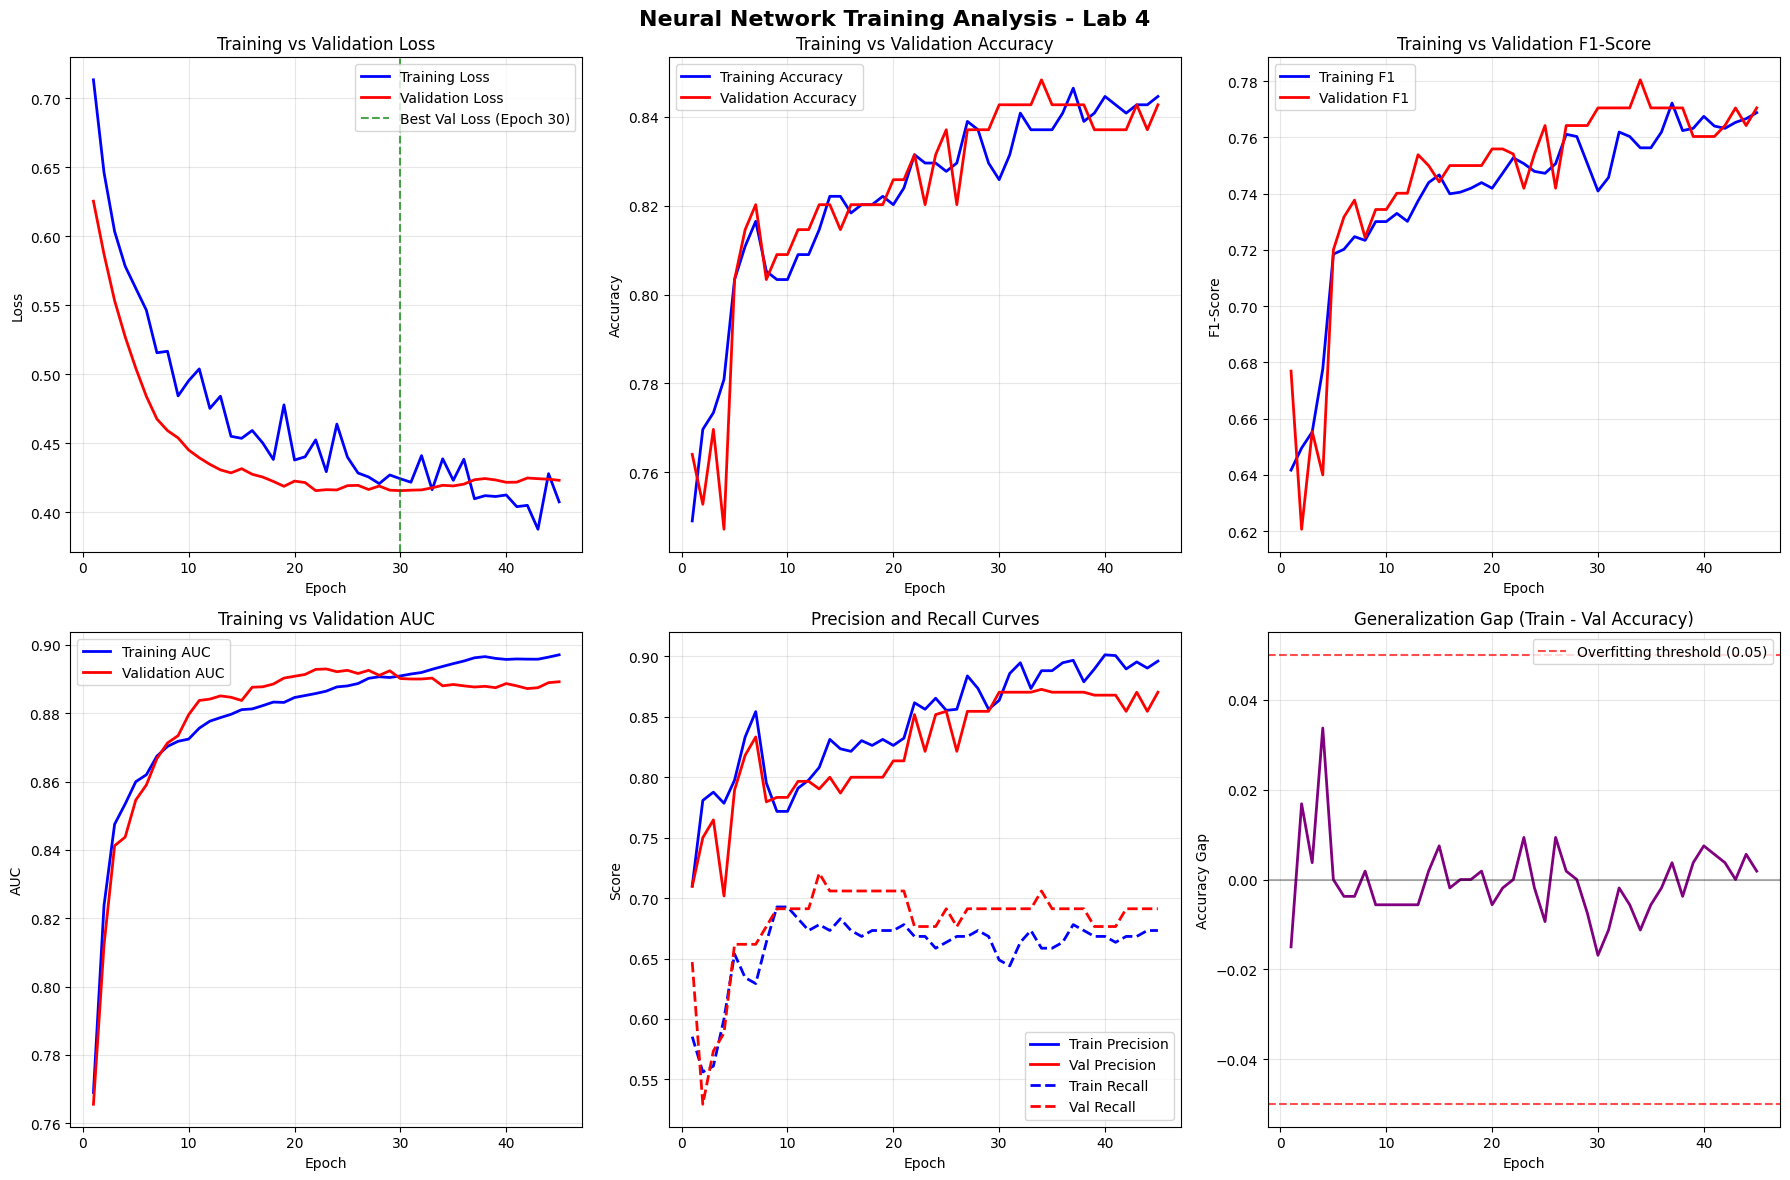

📊 Learning Curve Analysis:
--------------------------------------------------
🔍 Overfitting Analysis:
   Final generalization gap: 0.0019
   Maximum generalization gap: 0.0337
   Best validation loss at epoch: 30
   Total epochs trained: 45
   Status: ✅ Good generalization

📈 Performance Trends (last 10 epochs):
   Validation accuracy: declining
   Validation loss: increasing

🏆 Best Performance Achieved:
   Best validation accuracy: 0.8483 (epoch 34)
   Best validation F1-score: 0.7805 (epoch 34)
   Best validation AUC: 0.8930 (epoch 23)

✅ Task 6 completed: Learning curves analysis finished


In [9]:
# Task 6: Learning Curves and Visualization
print("="*50)
print("TASK 6: LEARNING CURVES AND VISUALIZATION")
print("="*50)

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Neural Network Training Analysis - Lab 4', fontsize=16, fontweight='bold')

# 1. Loss curves
epochs_range = range(1, len(train_losses) + 1)
axes[0, 0].plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Training vs Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Find overfitting point
min_val_loss_idx = np.argmin(val_losses)
axes[0, 0].axvline(x=min_val_loss_idx + 1, color='green', linestyle='--', alpha=0.7,
                   label=f'Best Val Loss (Epoch {min_val_loss_idx + 1})')
axes[0, 0].legend()

# 2. Accuracy curves
train_accuracies = [metrics['accuracy'] for metrics in train_metrics_history]
val_accuracies = [metrics['accuracy'] for metrics in val_metrics_history]

axes[0, 1].plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
axes[0, 1].plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Training vs Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. F1-Score curves
train_f1_scores = [metrics['f1'] for metrics in train_metrics_history]
val_f1_scores = [metrics['f1'] for metrics in val_metrics_history]

axes[0, 2].plot(epochs_range, train_f1_scores, 'b-', label='Training F1', linewidth=2)
axes[0, 2].plot(epochs_range, val_f1_scores, 'r-', label='Validation F1', linewidth=2)
axes[0, 2].set_title('Training vs Validation F1-Score')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. AUC curves
train_aucs = [metrics['auc'] for metrics in train_metrics_history]
val_aucs = [metrics['auc'] for metrics in val_metrics_history]

axes[1, 0].plot(epochs_range, train_aucs, 'b-', label='Training AUC', linewidth=2)
axes[1, 0].plot(epochs_range, val_aucs, 'r-', label='Validation AUC', linewidth=2)
axes[1, 0].set_title('Training vs Validation AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Precision and Recall curves
train_precisions = [metrics['precision'] for metrics in train_metrics_history]
train_recalls = [metrics['recall'] for metrics in train_metrics_history]
val_precisions = [metrics['precision'] for metrics in val_metrics_history]
val_recalls = [metrics['recall'] for metrics in val_metrics_history]

axes[1, 1].plot(epochs_range, train_precisions, 'b-', label='Train Precision', linewidth=2)
axes[1, 1].plot(epochs_range, val_precisions, 'r-', label='Val Precision', linewidth=2)
axes[1, 1].plot(epochs_range, train_recalls, 'b--', label='Train Recall', linewidth=2)
axes[1, 1].plot(epochs_range, val_recalls, 'r--', label='Val Recall', linewidth=2)
axes[1, 1].set_title('Precision and Recall Curves')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Overfitting analysis
generalization_gap = np.array(train_accuracies) - np.array(val_accuracies)
axes[1, 2].plot(epochs_range, generalization_gap, 'purple', linewidth=2)
axes[1, 2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 2].set_title('Generalization Gap (Train - Val Accuracy)')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Accuracy Gap')
axes[1, 2].grid(True, alpha=0.3)

# Add horizontal line at gap threshold
gap_threshold = 0.05
axes[1, 2].axhline(y=gap_threshold, color='red', linestyle='--', alpha=0.7,
                   label=f'Overfitting threshold ({gap_threshold})')
axes[1, 2].axhline(y=-gap_threshold, color='red', linestyle='--', alpha=0.7)
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Analysis summary
print(f"📊 Learning Curve Analysis:")
print(f"-" * 50)

# Overfitting detection
final_gap = generalization_gap[-1]
max_gap = np.max(generalization_gap)
min_val_loss_epoch = min_val_loss_idx + 1
total_epochs_trained = len(train_losses)

print(f"🔍 Overfitting Analysis:")
print(f"   Final generalization gap: {final_gap:.4f}")
print(f"   Maximum generalization gap: {max_gap:.4f}")
print(f"   Best validation loss at epoch: {min_val_loss_epoch}")
print(f"   Total epochs trained: {total_epochs_trained}")

if final_gap > 0.05:
    overfitting_status = "⚠️ Moderate overfitting detected"
elif final_gap > 0.1:
    overfitting_status = "🚨 Significant overfitting detected"
else:
    overfitting_status = "✅ Good generalization"

print(f"   Status: {overfitting_status}")

# Performance trends
val_acc_trend = "improving" if val_accuracies[-1] > val_accuracies[max(0, len(val_accuracies)-10)] else "declining"
val_loss_trend = "improving" if val_losses[-1] < val_losses[max(0, len(val_losses)-10)] else "increasing"

print(f"\n📈 Performance Trends (last 10 epochs):")
print(f"   Validation accuracy: {val_acc_trend}")
print(f"   Validation loss: {val_loss_trend}")

# Best performance summary
best_val_acc = max(val_accuracies)
best_val_f1 = max(val_f1_scores)
best_val_auc = max(val_aucs)

print(f"\n🏆 Best Performance Achieved:")
print(f"   Best validation accuracy: {best_val_acc:.4f} (epoch {val_accuracies.index(best_val_acc)+1})")
print(f"   Best validation F1-score: {best_val_f1:.4f} (epoch {val_f1_scores.index(best_val_f1)+1})")
print(f"   Best validation AUC: {best_val_auc:.4f} (epoch {val_aucs.index(best_val_auc)+1})")

print("\n✅ Task 6 completed: Learning curves analysis finished")

TASK 7: FINAL MODEL EVALUATION
🧪 Final evaluation on test set...

📊 Test Set Performance:
   Loss: 0.4538
   Accuracy: 0.8045
   Precision: 0.8696
   Recall: 0.5797
   F1: 0.6957
   Auc: 0.8461


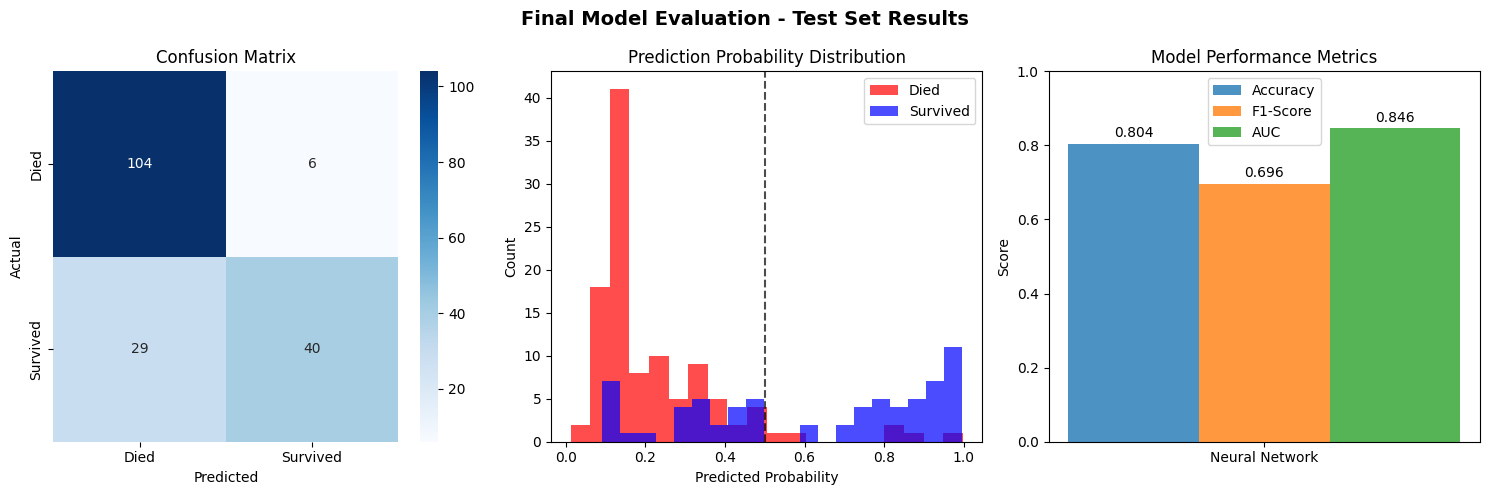


📋 Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

        Died     0.7820    0.9455    0.8560       110
    Survived     0.8696    0.5797    0.6957        69

    accuracy                         0.8045       179
   macro avg     0.8258    0.7626    0.7758       179
weighted avg     0.8157    0.8045    0.7942       179


📊 Model Analysis Summary:

🧠 Architecture Summary:
   Model type: Multi-Layer Perceptron (MLP)
   Input features: 13
   Hidden layers: 3 layers (64 → 32 → 16)
   Activation functions: ReLU (hidden), Sigmoid (output)
   Regularization: Dropout (0.3), Weight decay (1e-5)
   Total parameters: 3,521

⚙️ Training Configuration:
   Optimizer: Adam (lr=0.001)
   Loss function: Binary Cross-Entropy
   Batch size: 32
   Epochs trained: 45
   Early stopping: 15 epochs patience

🎯 Final Performance:
   Test Accuracy: 0.8045
   Test Precision: 0.8696
   Test Recall: 0.5797
   Test 

In [10]:
# Task 7: Final Model Evaluation and Test Results
print("="*50)
print("TASK 7: FINAL MODEL EVALUATION")
print("="*50)

# Evaluate on test set
print("🧪 Final evaluation on test set...")
test_loss, test_metrics = evaluate_model(model, test_loader, criterion, device)

print(f"\n📊 Test Set Performance:")
print(f"   Loss: {test_loss:.4f}")
for metric, value in test_metrics.items():
    print(f"   {metric.capitalize()}: {value:.4f}")

# Get predictions for confusion matrix
model.eval()
test_predictions = []
test_targets = []
test_probabilities = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        probabilities = outputs.squeeze().cpu().numpy()
        predictions = (probabilities > 0.5).astype(int)

        test_predictions.extend(predictions)
        test_probabilities.extend(probabilities)
        test_targets.extend(targets.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(test_targets, test_predictions)

# Visualization of final results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Final Model Evaluation - Test Set Results', fontsize=14, fontweight='bold')

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Died', 'Survived'])
axes[0].set_yticklabels(['Died', 'Survived'])

# 2. Prediction Probability Distribution
axes[1].hist([p for p, t in zip(test_probabilities, test_targets) if t == 0],
             bins=20, alpha=0.7, label='Died', color='red')
axes[1].hist([p for p, t in zip(test_probabilities, test_targets) if t == 1],
             bins=20, alpha=0.7, label='Survived', color='blue')
axes[1].set_title('Prediction Probability Distribution')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Count')
axes[1].legend()
axes[1].axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Decision Threshold')

# 3. Performance Comparison
models = ['Neural Network']
accuracies = [test_metrics['accuracy']]
f1_scores = [test_metrics['f1']]
aucs = [test_metrics['auc']]

x = np.arange(len(models))
width = 0.25

axes[2].bar(x - width, accuracies, width, label='Accuracy', alpha=0.8)
axes[2].bar(x, f1_scores, width, label='F1-Score', alpha=0.8)
axes[2].bar(x + width, aucs, width, label='AUC', alpha=0.8)

axes[2].set_title('Model Performance Metrics')
axes[2].set_ylabel('Score')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models)
axes[2].legend()
axes[2].set_ylim(0, 1)

# Add value labels on bars
for i, (acc, f1, auc) in enumerate(zip(accuracies, f1_scores, aucs)):
    axes[2].text(i - width, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')
    axes[2].text(i, f1 + 0.01, f'{f1:.3f}', ha='center', va='bottom')
    axes[2].text(i + width, auc + 0.01, f'{auc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Detailed classification report
from sklearn.metrics import classification_report

print(f"\n📋 Detailed Classification Report:")
print("-" * 60)
print(classification_report(test_targets, test_predictions,
                          target_names=['Died', 'Survived'], digits=4))

# Model analysis summary
print(f"\n📊 Model Analysis Summary:")
print("=" * 60)

print(f"\n🧠 Architecture Summary:")
print(f"   Model type: Multi-Layer Perceptron (MLP)")
print(f"   Input features: {num_features}")
print(f"   Hidden layers: 3 layers (64 → 32 → 16)")
print(f"   Activation functions: ReLU (hidden), Sigmoid (output)")
print(f"   Regularization: Dropout (0.3), Weight decay (1e-5)")
print(f"   Total parameters: {total_params:,}")

print(f"\n⚙️ Training Configuration:")
print(f"   Optimizer: Adam (lr=0.001)")
print(f"   Loss function: Binary Cross-Entropy")
print(f"   Batch size: {batch_size}")
print(f"   Epochs trained: {len(train_losses)}")
print(f"   Early stopping: {early_stopping_patience} epochs patience")

print(f"\n🎯 Final Performance:")
print(f"   Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"   Test Precision: {test_metrics['precision']:.4f}")
print(f"   Test Recall: {test_metrics['recall']:.4f}")
print(f"   Test F1-Score: {test_metrics['f1']:.4f}")
print(f"   Test AUC: {test_metrics['auc']:.4f}")

print(f"\n🔍 Generalization Analysis:")
final_train_acc = train_metrics_final['accuracy']
final_val_acc = val_metrics_final['accuracy']
final_test_acc = test_metrics['accuracy']

print(f"   Training accuracy: {final_train_acc:.4f}")
print(f"   Validation accuracy: {final_val_acc:.4f}")
print(f"   Test accuracy: {final_test_acc:.4f}")
print(f"   Train-Val gap: {final_train_acc - final_val_acc:.4f}")
print(f"   Val-Test gap: {final_val_acc - final_test_acc:.4f}")

if abs(final_val_acc - final_test_acc) < 0.02:
    generalization_quality = "✅ Excellent generalization"
elif abs(final_val_acc - final_test_acc) < 0.05:
    generalization_quality = "✅ Good generalization"
else:
    generalization_quality = "⚠️ Potential generalization issues"

print(f"   Generalization quality: {generalization_quality}")

print(f"\n🏁 Lab 4 Summary:")
print(f"   ✅ Successfully implemented MLP with PyTorch")
print(f"   ✅ Achieved {test_metrics['accuracy']:.1%} test accuracy")
print(f"   ✅ Implemented proper training pipeline with early stopping")
print(f"   ✅ Generated comprehensive learning curves analysis")
print(f"   ✅ Demonstrated understanding of overfitting detection")

print("\n✅ Task 7 completed: Final evaluation and summary report finished")
print("\n🎉 Lab 4: Neural Network Implementation - COMPLETED! 🎉")